In [5]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


In [14]:
fake_df = pd.read_csv("News _dataset/Fake.csv")
true_df = pd.read_csv("News _dataset/True.csv")

In [31]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
fake_data = fake_df.text.values.tolist()
fake_data_words = list(sent_to_words(fake_data))
print(fake_data_words[:1])


[['donald', 'trump', 'just', 'couldn', 'wish', 'all', 'americans', 'happy', 'new', 'year', 'and', 'leave', 'it', 'at', 'that', 'instead', 'he', 'had', 'to', 'give', 'shout', 'out', 'to', 'his', 'enemies', 'haters', 'and', 'the', 'very', 'dishonest', 'fake', 'news', 'media', 'the', 'former', 'reality', 'show', 'star', 'had', 'just', 'one', 'job', 'to', 'do', 'and', 'he', 'couldn', 'do', 'it', 'as', 'our', 'country', 'rapidly', 'grows', 'stronger', 'and', 'smarter', 'want', 'to', 'wish', 'all', 'of', 'my', 'friends', 'supporters', 'enemies', 'haters', 'and', 'even', 'the', 'very', 'dishonest', 'fake', 'news', 'media', 'happy', 'and', 'healthy', 'new', 'year', 'president', 'angry', 'pants', 'tweeted', 'will', 'be', 'great', 'year', 'for', 'america', 'as', 'our', 'country', 'rapidly', 'grows', 'stronger', 'and', 'smarter', 'want', 'to', 'wish', 'all', 'of', 'my', 'friends', 'supporters', 'enemies', 'haters', 'and', 'even', 'the', 'very', 'dishonest', 'fake', 'news', 'media', 'happy', 'and'

In [32]:
#for true news
true_data = true_df.text.values.tolist()
true_data_words = list(sent_to_words(true_data))
print(true_data_words[:1])

[['washington', 'reuters', 'the', 'head', 'of', 'conservative', 'republican', 'faction', 'in', 'the', 'congress', 'who', 'voted', 'this', 'month', 'for', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', 'in', 'keeping', 'with', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'federal', 'budget', 'in', 'fight', 'likely', 'to', 'be', 'linked', 'to', 'other', 'issues', 'such', 'as', 'immigration', 'policy', 'even', 'as', 'the', 'november', 'congressional', 'election', 'campaigns', 'appro

In [33]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(fake_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[fake_data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [34]:
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

In [37]:
fake_data_ready = process_words(fake_data_words) 

In [38]:
id2word = corpora.Dictionary(fake_data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in fake_data_ready]


In [39]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=4,random_state=100,update_every=1,chunksize=10,
                                            passes=10,
                                            alpha='symmetric',
                                            iterations=100,
                                            per_word_topics=True)

In [40]:
pprint(lda_model.print_topics())

[(0,
  '0.017*"government" + 0.016*"report" + 0.012*"official" + 0.009*"accord" + '
  '0.009*"case" + 0.009*"source" + 0.009*"russian" + 0.008*"story" + '
  '0.008*"claim" + 0.008*"state"'),
 (1,
  '0.013*"medium" + 0.013*"trump" + 0.008*"news" + 0.007*"event" + '
  '0.006*"time" + 0.006*"people" + 0.006*"political" + 0.005*"week" + '
  '0.005*"show" + 0.005*"call"'),
 (2,
  '0.017*"terrorist" + 0.016*"police" + 0.013*"shoot" + 0.012*"attack" + '
  '0.011*"kill" + 0.010*"group" + 0.010*"man" + 0.009*"protest" + '
  '0.008*"terror" + 0.008*"incident"'),
 (3,
  '0.013*"state" + 0.008*"year" + 0.008*"country" + 0.007*"military" + '
  '0.007*"policy" + 0.006*"new" + 0.006*"crisis" + 0.006*"public" + '
  '0.005*"american" + 0.005*"world"')]


In [43]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=fake_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)



df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=fake_data_ready)



# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8779,"medium, trump, news, event, time, people, poli...","[year, leave, instead, give, shout, enemy, hat..."
1,1,0.0,0.4749,"government, report, official, accord, case, so...","[nune, bad, day, assumption, dossier, prompt, ..."
2,2,1.0,0.7015,"medium, trump, news, event, time, people, poli...","[reveal, former, consider, email, scandal, bri..."
3,3,1.0,0.7649,"medium, trump, news, event, time, people, poli...","[announce, work, follow, day, golf, fourth, da..."
4,4,1.0,0.5854,"medium, trump, news, event, time, people, poli...","[annual, message, trump, mention, name, delive..."
5,5,2.0,0.4898,"terrorist, police, shoot, attack, kill, group,...","[number, case, cop, brutalize, kill, people, c..."
6,6,1.0,0.5913,"medium, trump, news, event, time, people, poli...","[spend, day, mark, day, oath, office, must, ba..."
7,7,1.0,0.5842,"medium, trump, news, event, time, people, poli...","[wake, yet, court, decision, derail, plan, bar..."
8,8,1.0,0.5763,"medium, trump, news, event, time, people, poli...","[people, raise, alarm, regard, fact, become, a..."
9,9,1.0,0.7927,"medium, trump, news, event, time, people, poli...","[break, watch, people, kiss, stroke, ego, pro,..."


In [44]:
#Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9057,"government, report, official, accord, case, source, russian, story, claim, state","[charge, crook, careless, recommend, charge, already, recommendation, clinton, email, contain, c..."
1,1.0,0.9932,"medium, trump, news, event, time, people, political, week, show, call","[surprised, recently, discover, display, fake, time, magazine, feature, cover, star, fake, magaz..."
2,2.0,0.8711,"terrorist, police, shoot, attack, kill, group, man, protest, terror, incident","[video, second, load, black, box, loading]"
3,3.0,0.9040,"state, year, country, military, policy, new, crisis, public, american, world","[bernie, fan, look, berniesander, leave, behind, much, cost, pay, much, cost, plan, estimate, co..."


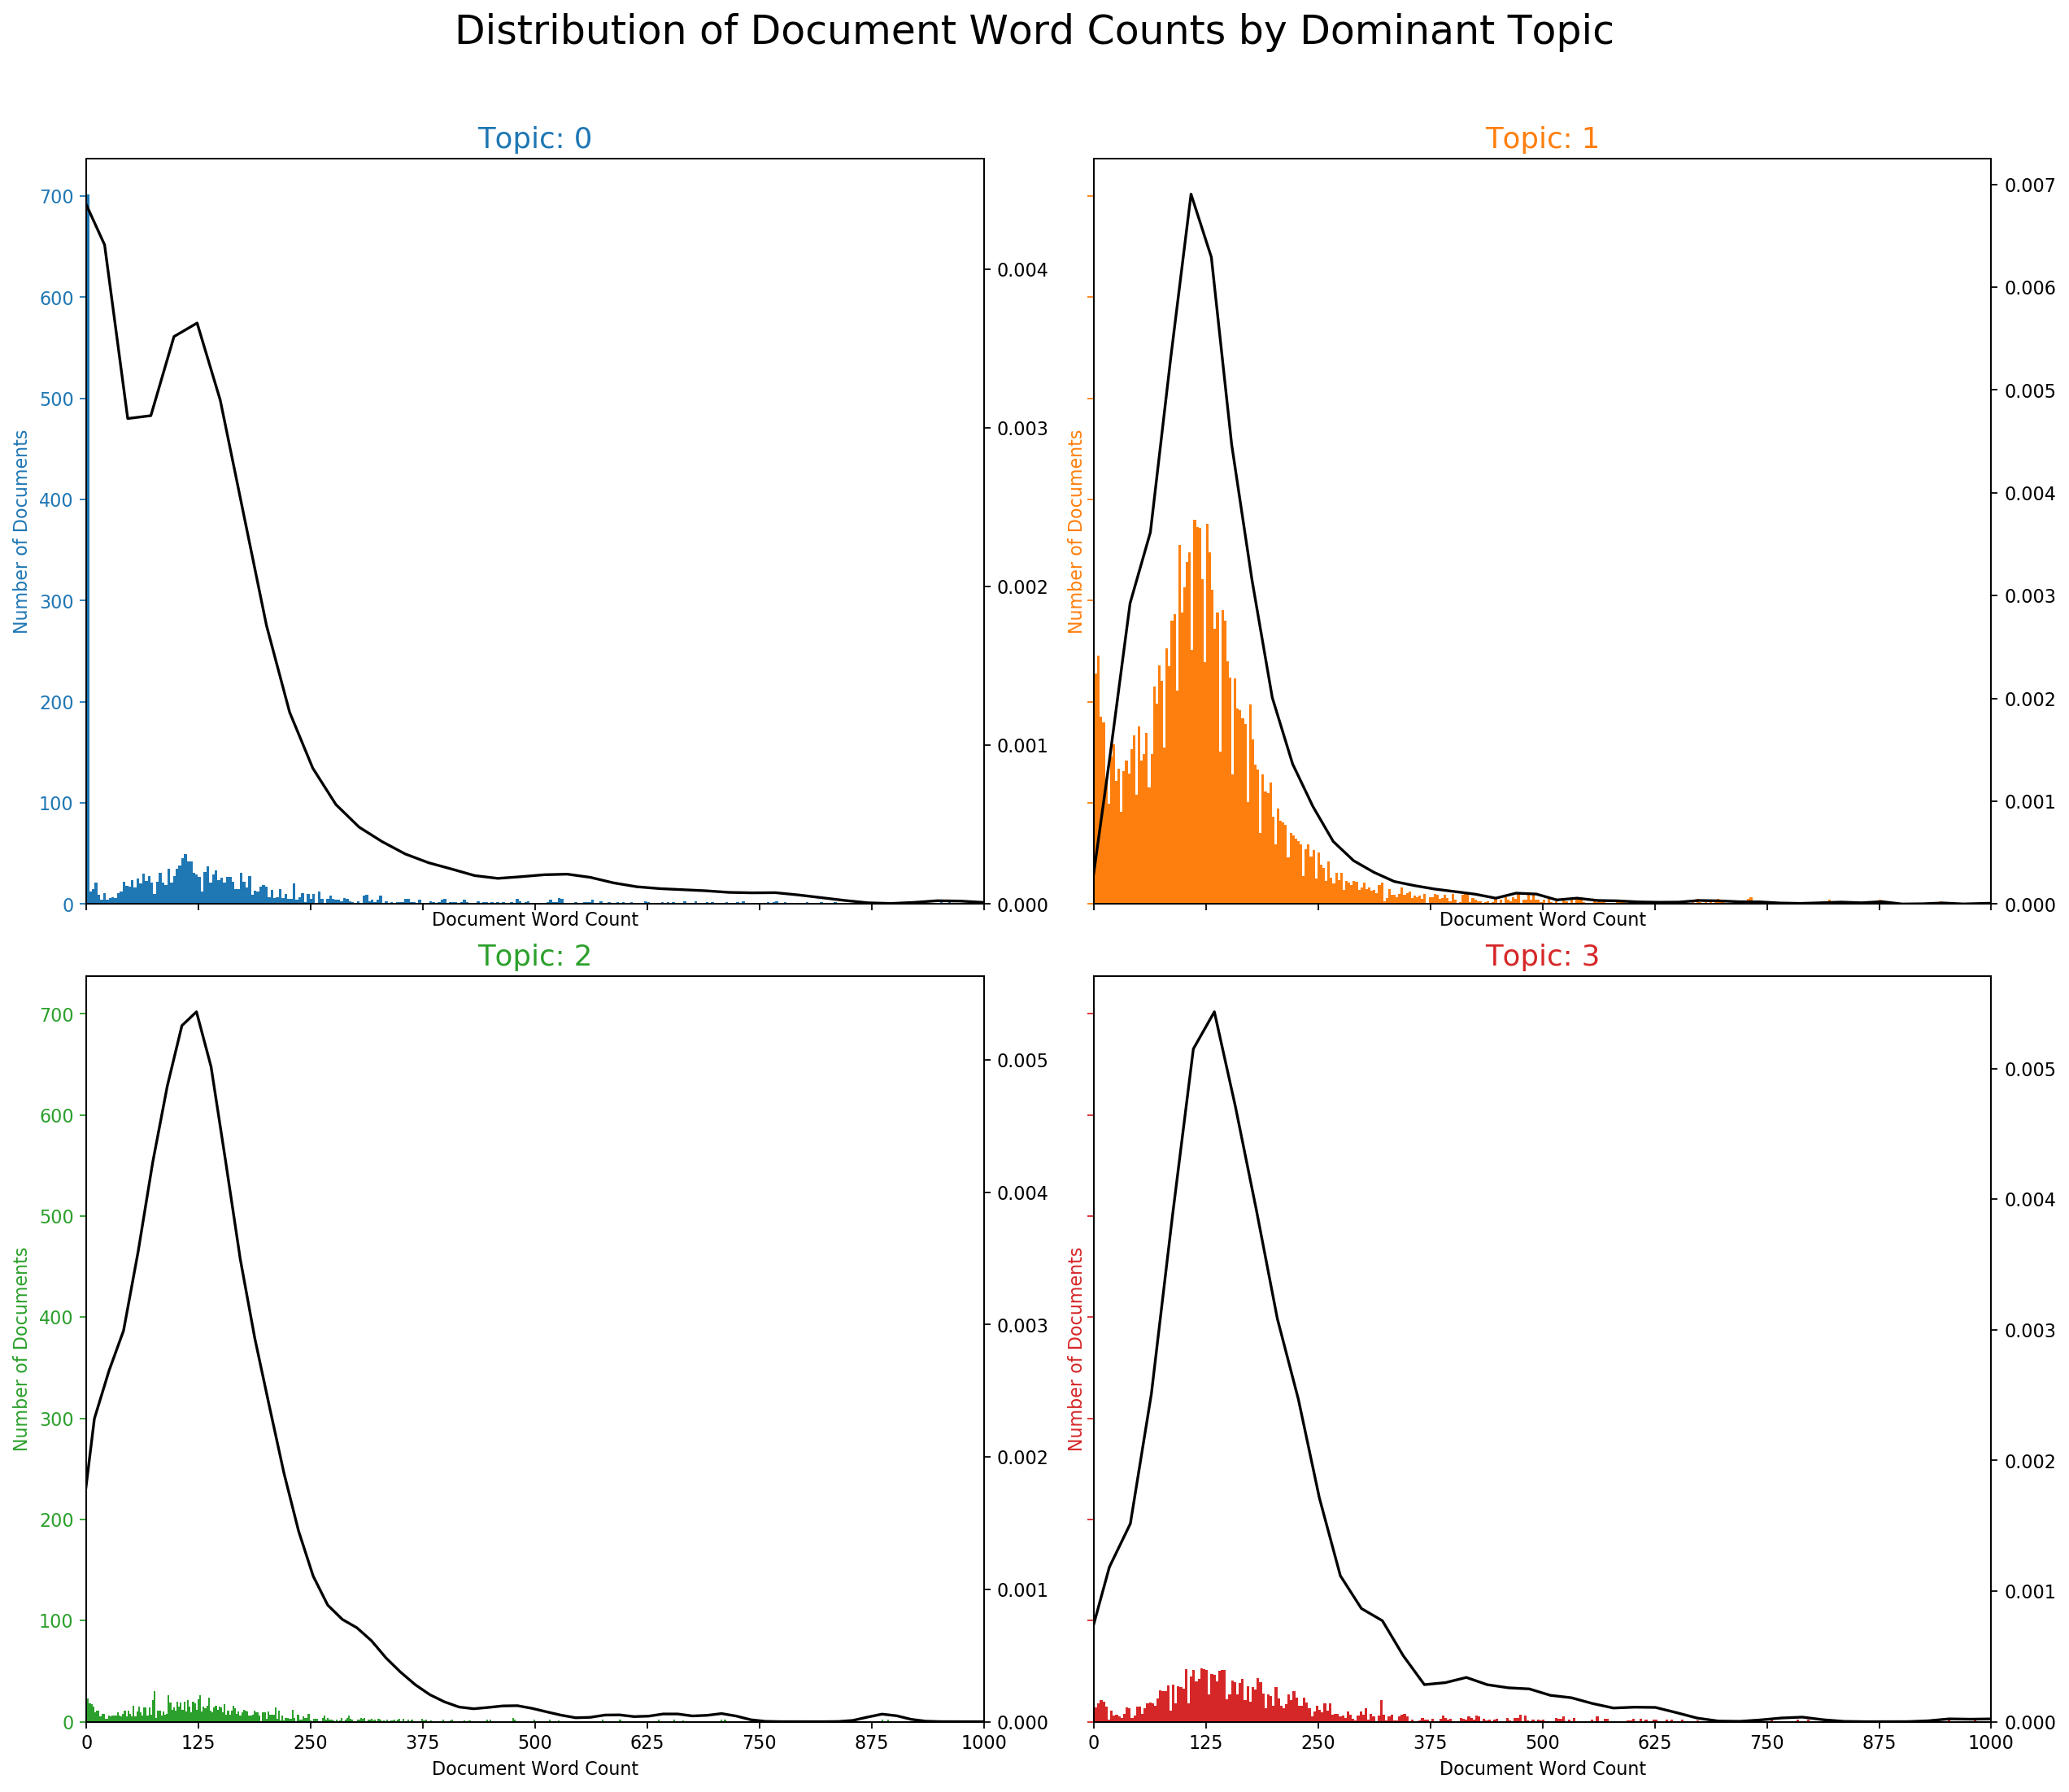

In [45]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

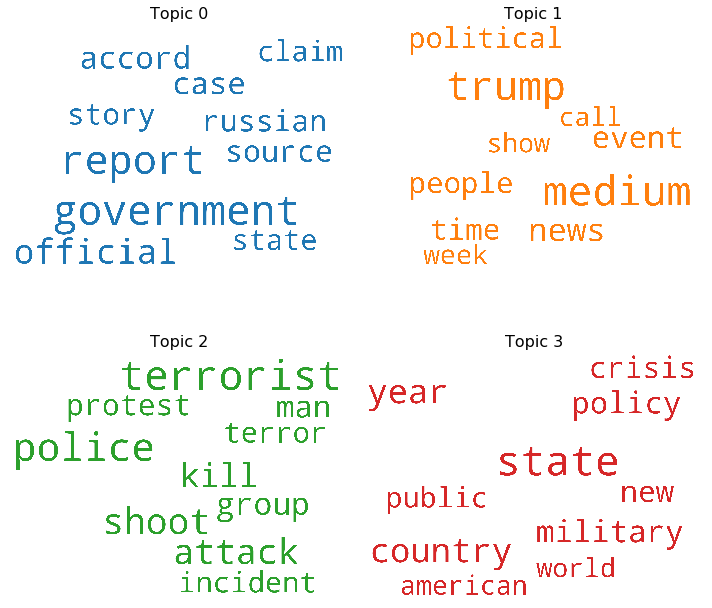

In [48]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',width=2500,
                  height=1800,
                  max_words=40,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [56]:
topic_words

{'state': 0.013202174,
 'year': 0.008453383,
 'country': 0.008444732,
 'military': 0.0069053606,
 'policy': 0.006696125,
 'new': 0.0063767973,
 'crisis': 0.0063622007,
 'public': 0.005764289,
 'american': 0.005021637,
 'world': 0.004990282}